In [17]:
# 1. 라이브러리 불러오기
import pandas as pd

# 2. 파일 경로 설정 (data 폴더 기준)
unemployment_file = "./data/성_연령별_실업자.xlsx"
marriage_file = "./data/혼인_건수.csv"

# 3. 실업자 수 데이터 불러오기 및 전처리
unemp_df = pd.read_excel(unemployment_file, sheet_name='데이터')
unemp_df['성별'].fillna(method='ffill', inplace=True)

# 사용할 연령/성별 조합
ages = ['20 - 29세', '30 - 39세']
sexes = ['남자', '여자']

# 연도 컬럼만 필터링
year_cols = [col for col in unemp_df.columns if isinstance(col, str) and col.startswith('20')]
year_cols = [col for col in year_cols if 2001.0 <= float(col) <= 2022.06]

# 성별+연령 조합별 평균 실업자 수 계산
unemp_result = []
for gender in sexes:
    for age in ages:
        subset = unemp_df[(unemp_df['성별'] == gender) & (unemp_df['연령계층별'] == age)]
        if not subset.empty:
            mean_series = subset[year_cols].T.mean(axis=1)
            mean_series.index = pd.to_datetime(mean_series.index).year
            mean_series = mean_series.groupby(mean_series.index).mean()
            df_temp = pd.DataFrame({
                '연도': mean_series.index,
                '연령대': '20대' if '20' in age else '30대',
                '성별': gender,
                '값': mean_series.values * 1000,  # 천명 → 명
                '지표': '실업자 수'
            })
            unemp_result.append(df_temp)

unemployment_final = pd.concat(unemp_result, ignore_index=True)

# 4. 혼인 건수 데이터 불러오기 및 전처리
marriage_df = pd.read_csv(marriage_file)

def get_age_group(age_str):
    try:
        age = int(age_str.replace("세", ""))
        if 20 <= age <= 29:
            return '20대'
        elif 30 <= age <= 39:
            return '30대'
    except:
        return None

marriage_df['아내_연령대'] = marriage_df['아내의 연령별'].apply(get_age_group)
marriage_df['남편_연령대'] = marriage_df['남편의 연령별'].apply(get_age_group)
year_columns = [col for col in marriage_df.columns if '년' in col]
clean_year_columns = [int(col.replace(" 년", "")) for col in year_columns]

# 아내 기준
female = marriage_df[marriage_df['아내_연령대'].isin(['20대', '30대'])]
female_grouped = female.groupby('아내_연령대')[year_columns].sum().T
female_grouped['연도'] = clean_year_columns
female_grouped = female_grouped.melt(id_vars='연도', var_name='연령대', value_name='값')
female_grouped['성별'] = '여자'
female_grouped['지표'] = '혼인 건수'

# 남편 기준
male = marriage_df[marriage_df['남편_연령대'].isin(['20대', '30대'])]
male_grouped = male.groupby('남편_연령대')[year_columns].sum().T
male_grouped['연도'] = clean_year_columns
male_grouped = male_grouped.melt(id_vars='연도', var_name='연령대', value_name='값')
male_grouped['성별'] = '남자'
male_grouped['지표'] = '혼인 건수'

# 혼인 데이터 합치기
marriage_final = pd.concat([female_grouped, male_grouped], ignore_index=True)

# 5. 실업자 + 혼인 건수 통합
final_df = pd.concat([unemployment_final, marriage_final], ignore_index=True)

# 6. 연도 2001~2022년 누락 방지 - 모든 조합 채우기
full_years = list(range(2001, 2023))
age_groups = ['20대', '30대']
sexes = ['남자', '여자']
kinds = ['실업자 수', '혼인 건수']

from itertools import product
full_index = pd.DataFrame(product(full_years, age_groups, sexes, kinds), columns=['연도', '연령대', '성별', '지표'])

# 누락된 조합 보완
final_df = pd.merge(full_index, final_df, how='left', on=['연도', '연령대', '성별', '지표'])
final_df['값'] = final_df['값'].fillna(0)  # 누락 데이터는 0으로 처리

# 7. 결과 미리보기
final_df = final_df.sort_values(by=['연도', '지표', '연령대', '성별'])
final_df.head(10)


C:\Users\smhrd\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\smhrd\AppData\Local\Temp\ipykernel_14600\3827249321.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unemp_df['성별'].fillna(method='ffill', inplace=True)
C:\Users\smhrd\AppData\Local\Temp\ipykernel_14600\3827249321.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in 

,연도,연령대,성별,지표,값
0,2001,20대,남자,실업자 수,210666.666667
2,2001,20대,여자,실업자 수,142000.000000
4,2001,30대,남자,실업자 수,147416.666667
6,2001,30대,여자,실업자 수,57666.666667
1,2001,20대,남자,혼인 건수,168305.000000
3,2001,20대,여자,혼인 건수,231072.000000
5,2001,30대,남자,혼인 건수,116698.000000
7,2001,30대,여자,혼인 건수,59006.000000
8,2002,20대,남자,실업자 수,195666.666667
10,2002,20대,여자,실업자 수,122500.000000


In [41]:
final_df

,연령대,성별,지표,값
연도,,,,
2001,20대,남자,실업자 수,210666.666667
2001,20대,여자,실업자 수,142000.000000
2001,30대,남자,실업자 수,147416.666667
2001,30대,여자,실업자 수,57666.666667
2001,20대,남자,혼인 건수,168305.000000
...,...,...,...,...
2022,30대,여자,실업자 수,75666.666667
2022,20대,남자,혼인 건수,41638.000000
2022,20대,여자,혼인 건수,69119.000000


In [39]:
final_df.set_index("연도", inplace=True)

In [51]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

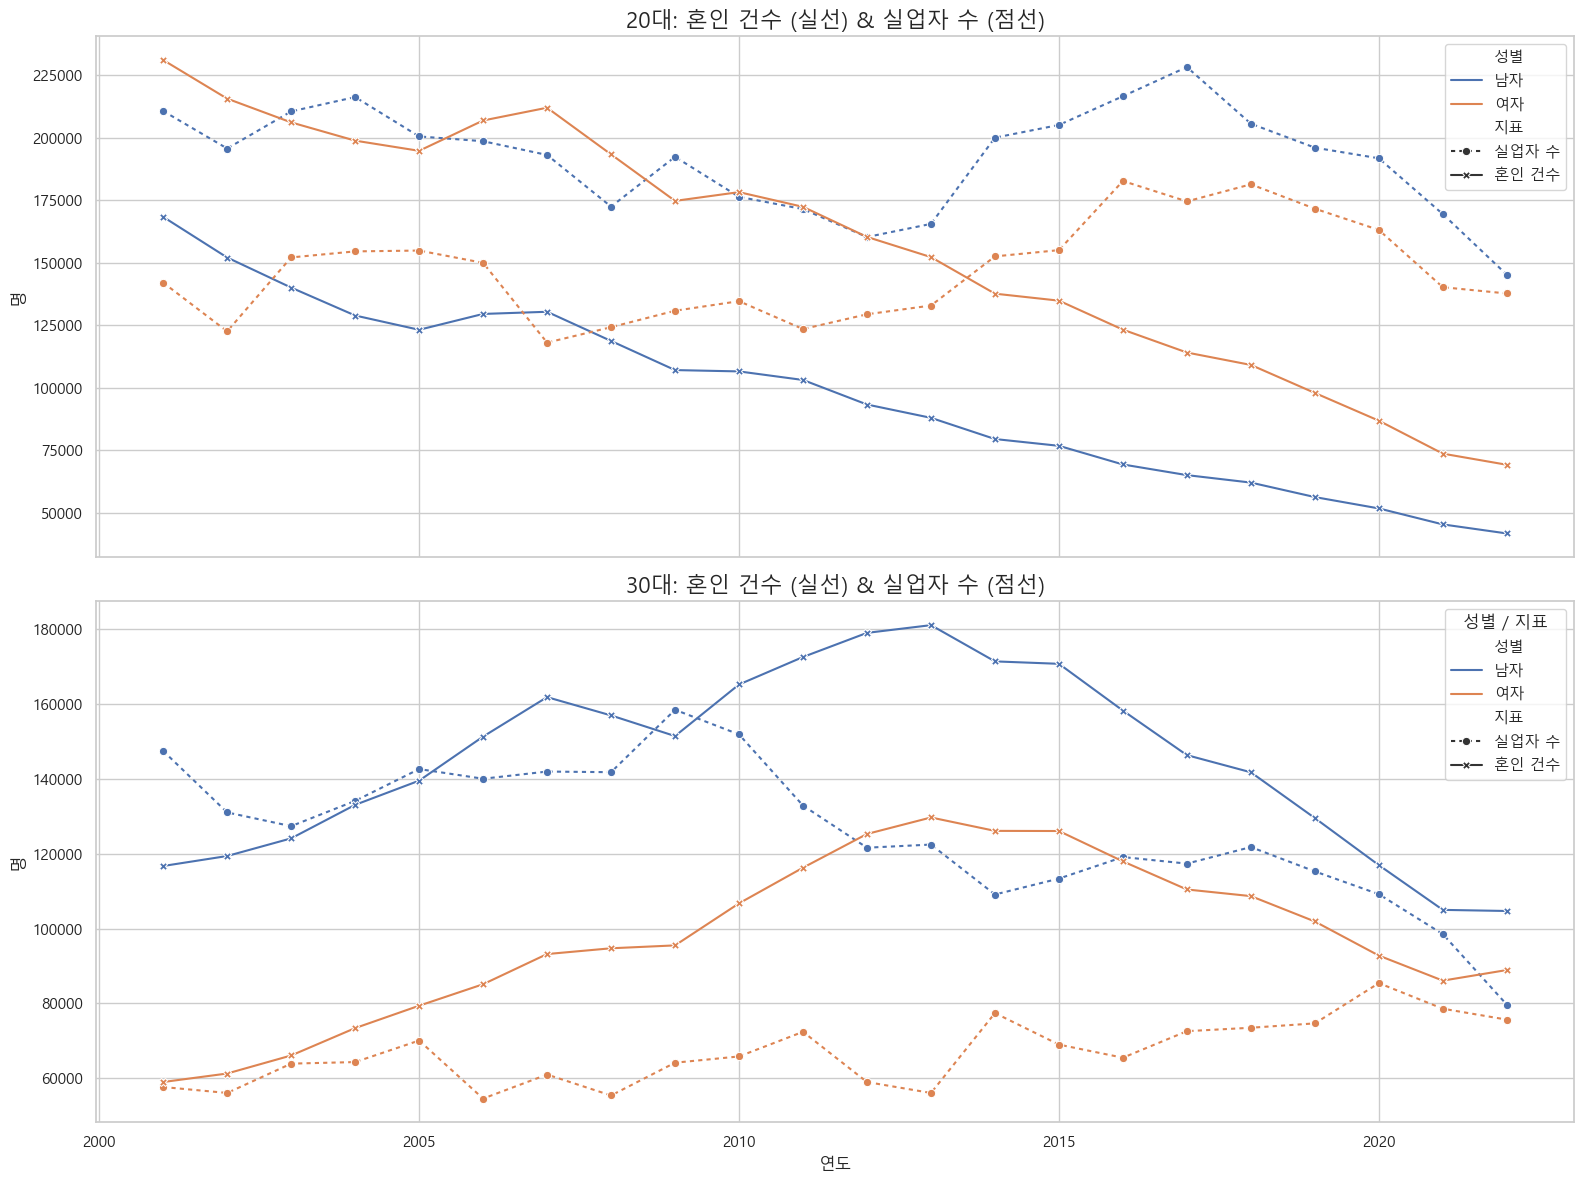

In [47]:
# 1. 20대 데이터와 30대 데이터를 각각 필터링
df_20 = final_df[final_df['연령대'] == '20대']
df_30 = final_df[final_df['연령대'] == '30대']

# 2. 한 화면에 2개의 서브플롯(그래프) 그리기
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)

# 3. 20대 그래프
# - 혼인 건수: 실선 (solid)
# - 실업자 수: 점선 (dotted)
sns.lineplot(
    data=df_20,
    x='연도', y='값',
    hue='성별', 
    style='지표', 
    markers=True,
    # dashes 설정: 혼인 건수 → 실선, 실업자 수 → 점선
    dashes={'혼인 건수': '', '실업자 수': (2,2)},
    ax=axes[0]
)
axes[0].set_title("20대: 혼인 건수 (실선) & 실업자 수 (점선)", fontsize=16)
axes[0].set_ylabel("명")
axes[0].grid(True)

# 4. 30대 그래프
sns.lineplot(
    data=df_30,
    x='연도', y='값',
    hue='성별', 
    style='지표', 
    markers=True,
    dashes={'혼인 건수': '', '실업자 수': (2,2)},
    ax=axes[1]
)
axes[1].set_title("30대: 혼인 건수 (실선) & 실업자 수 (점선)", fontsize=16)
axes[1].set_xlabel("연도")
axes[1].set_ylabel("명")
axes[1].grid(True)

# 5. 범례 설정
# 각 그래프에 대해 범례가 같이 나타나지만, 여기서는 30대 그래프의 범례를 사용합니다.
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, title="성별 / 지표", loc='upper right')

plt.tight_layout()
plt.show()


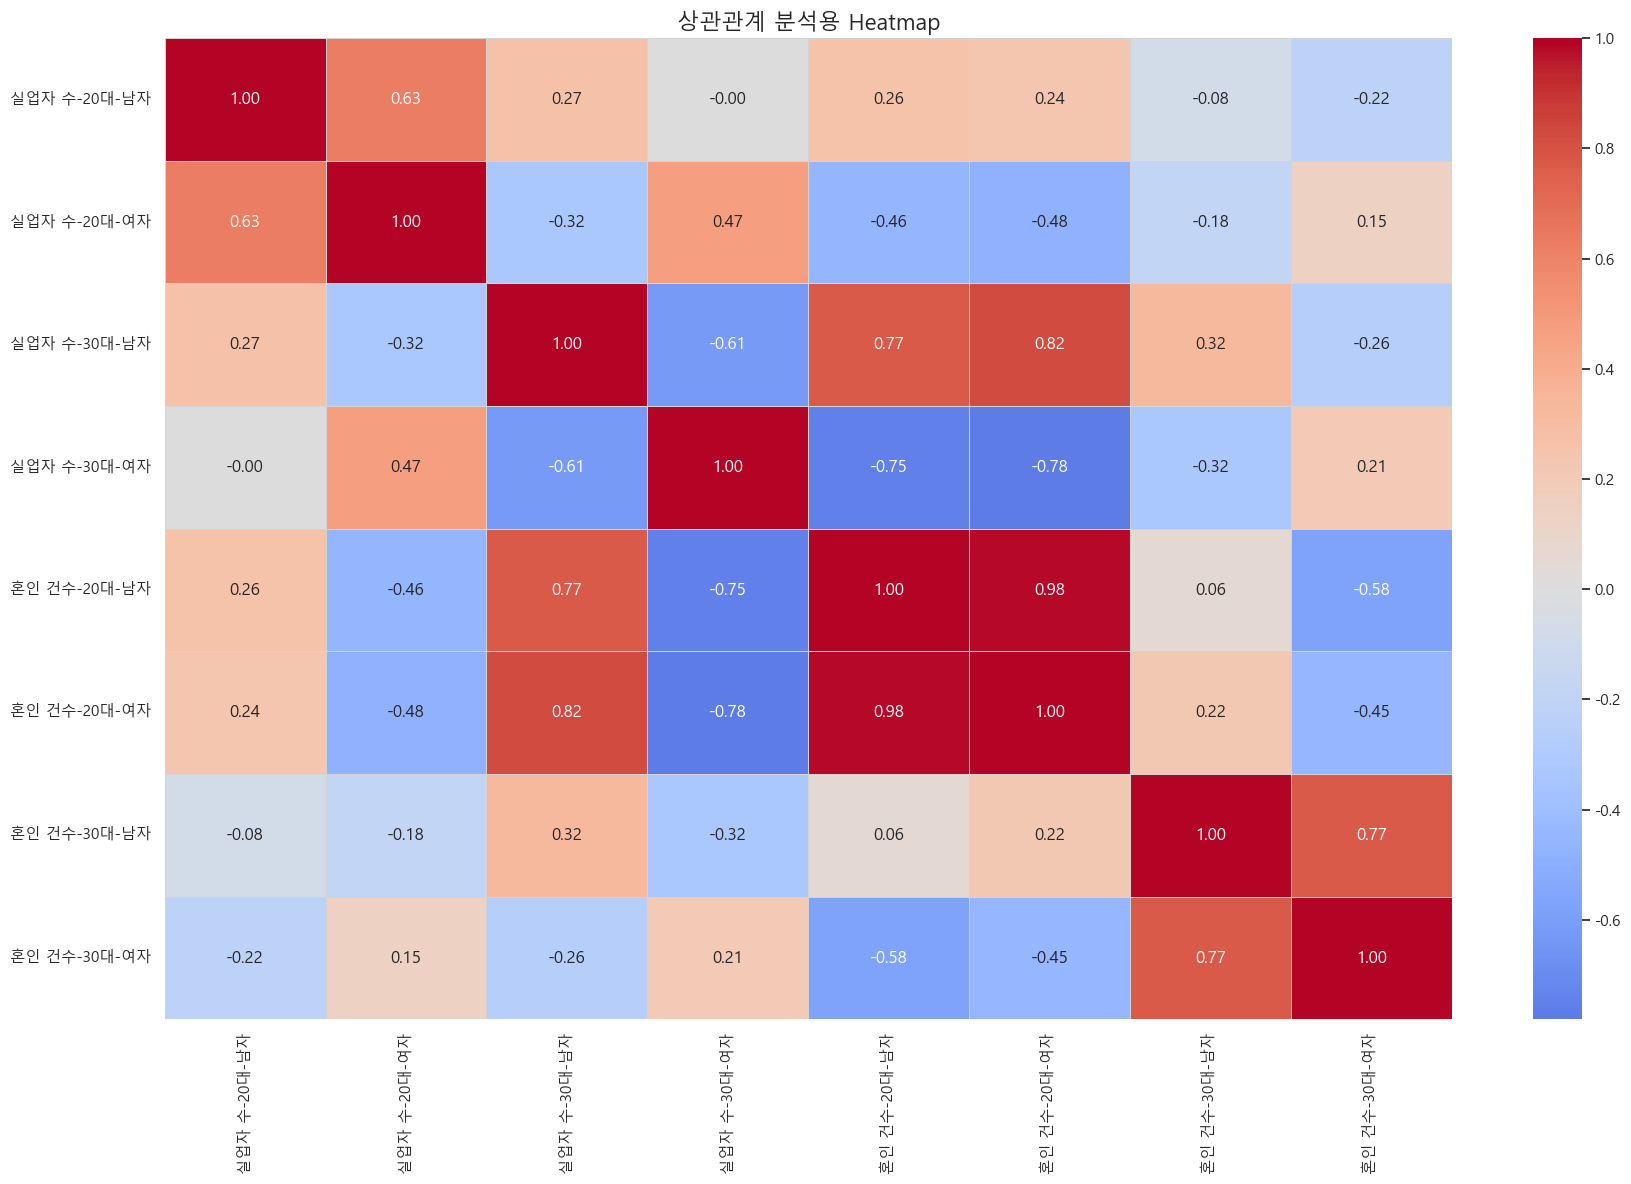

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 피벗: 연도별 각 집단의 시계열 (집단 = "지표-연령대-성별")
#    - aggfunc는 'mean' (연도별 해당 집단의 평균값; 경우에 따라 'sum'도 사용 가능)
pivot_data = final_df.pivot_table(
    index='연도',
    columns=['지표', '연령대', '성별'],
    values='값',
    aggfunc='mean'
)

# 2. 다중 인덱스 컬럼을 한 줄 문자열로 변환
pivot_data.columns = [f"{col[0]}-{col[1]}-{col[2]}" for col in pivot_data.columns]

# 3. 상관계수 행렬 계산
corr_matrix = pivot_data.corr()

# 4. 상관관계 Heatmap 그리기
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr_matrix,
    annot=True,         # 각 셀에 상관계수 수치 표시
    fmt=".2f",
    cmap="coolwarm",    # 색상 팔레트 (중심=0)
    center=0,
    linewidths=0.5,
    linecolor='lightgray'
)
plt.title("상관관계 분석용 Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


# 결론

>### 20대
>- 혼인 건수 : 남녀 모두 2001년 이후 지속적 하락.
>- 실업자 수 : 일시적 상승 구간이 있었으나, 혼인 건수와 상관된 변화는 보이지 않음.
>- 상관관계를 분석했을 때에도 남,녀 모두 0.26, -0.48로 두 변수 간 직접 인과관계 약함.

>### 30대
>- 혼인 건수 2010년 전후로 정점 이후 전반적 하락.
>- 실업자 수 : 남녀 모두 변동성이 크며 패턴이 일정하지 않음.
>- 남성의 경우 2010~2015년 실업자 수가 하락하고 혼인건수가 증가하는 패턴이 있지만, 상관관계 분석 결과 0.32, 0.21로 직접적인 인과관계는 약함.


>#### 남성이 여성에 비해서 상관관계가 비교적 높음.
>#### 20대의 혼인 건수의 지속적인 하락, 30대의 2013년 정점 이후 급하락은 실업률 변화와는 독립적으로 나타나는 경향이 있어, 혼인율 저하에 영향을 미치는 다양한 비경제적 요인들을 고려할 필요가 있다.
